In [65]:
1

1

In [66]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from typing import TypedDict, Literal
from langchain_core.messages import AIMessage

In [67]:
load_dotenv()

True

In [68]:
generator_llm = ChatGroq(model='llama3-70b-8192')
conditional_llm = ChatGroq(model='llama3-70b-8192')
score_llm = ChatGroq(model='llama3-70b-8192')

In [69]:
### defining State

class Joke(TypedDict):

    topic: str
    joke: str
    score: int
    feedback : Literal ['good', 'bad']
    social_media: Literal['yes', 'no']


In [70]:
def generator(state: Joke):

    prompt = f'You are a witty and clever comedian. I will give you a list of activities done in a day. Your task is to generate a short, humorous joke or one-liner that playfully summarizes the day. The joke should be light-hearted and suitable for all audiences Here is the list of activities: {state['topic']} Now, make a funny joke about this day!'

    response = generator_llm.invoke(prompt)
    return {'joke' : response}

In [71]:
def check(state: Joke):
    prompt = f"""
You are a humor critic and comedy expert. Given a joke and the list of activities it's based on, your task is to rate the joke on a scale of 1 to 10.

Joke: {state['joke']}

Rate the joke based on:
- Relevance
- Creativity
- Humor
- Clarity

Return your answer like this:
Score: <number>
Explanation: <brief explanation>
"""
    response = score_llm.invoke(prompt)

    # Extract score
    import re
    match = re.search(r"Score:\s*(\d+)", response.content)
    if match:
        score = int(match.group(1))
    else:
        score = 0  # fallback

    # Update state correctly
    return {
        'score': score,
        'feedback': 'good' if score > 5 else 'bad'
    }


In [72]:
def social_media(state:Joke):

    if state['score'] > 5:
        return {'social_media':'yes'}
    else:
        return {'social_media':'no'}

In [73]:
def conditional(state: Joke) -> Literal['generators', 'social_medias']:

    if state['feedback'] == 'good':
        return 'social_medias'
    else:
        return 'generators'


In [74]:
# ### graph
graph = StateGraph(Joke)

graph.add_node('generators', generator)
graph.add_node('check', check)
graph.add_node('social_medias', social_media)


graph.add_edge(START, 'generators')
graph.add_edge('generators','check')

graph.add_conditional_edges('check', conditional)
graph.add_edge('social_medias', END)

workflow = graph.compile()

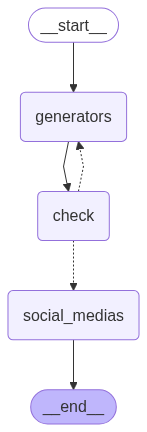

In [75]:
workflow

In [86]:
initial_state= {
    'topic': 'fuck good day with zero logic'
}
workflow.invoke(initial_state)


{'topic': 'fuck good day with zero logic',
 'joke': AIMessage(content='I think there might be some, ahem, "creative" language in that list! But don\'t worry, I\'ll take it as a challenge to craft a joke that\'s still family-friendly and funny.\n\nHere\'s a one-liner that playfully summarizes the day:\n\n"Today was a day where logic took a hike, but somehow, despite the chaos, I still managed to \'f\' things up in a good way – I mean, it\'s all about perspective, right?"\n\nLet me know if you\'d like me to come up with another one!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 114, 'prompt_tokens': 86, 'total_tokens': 200, 'completion_time': 0.581992192, 'prompt_time': 0.002390193, 'queue_time': 0.28216313000000004, 'total_time': 0.584382385}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--1bcdbe84-c435-4ddc-97a3-20fa5b299474-0', usage_metadata={'i